In [1]:
import pandas as pd
import numpy as np
import openassetpricing as oap
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
linear_r = LinearRegression()
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
!pip install shap
import shap

MLP = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000)

openap = oap.OpenAP()

In [22]:
pd.options.display.max_columns = 200

In [3]:
signal_df = openap.dl_signal_doc('pandas')

In [4]:
signal_df

,Acronym,Cat.Signal,Predictability in OP,Signal Rep Quality,Authors,Year,LongDescription,Journal,Cat.Form,Cat.Data,Cat.Economic,SampleStartYear,SampleEndYear,Acronym2,Evidence Summary,Key Table in OP,Test in OP,Sign,Return,T-Stat,Stock Weight,LS Quantile,Quantile Filter,Portfolio Period,Start Month,Filter,Notes,Detailed Definition
0,AbnormalAccruals,Predictor,1_clear,2_fair,Xie,2001,Abnormal Accruals,AR,continuous,Accounting,accruals,1971,1992,AccrAbn,t=8 port sort w/ nonstandard data lag,3,port sort size adjusted nonstandard,-1,0.916666667,8.43,EW,0.1,NA,12,6,NA,OP is aggressive and lags accounting data by o...,Define Accruals as net income (ib) minus opera...
1,Accruals,Predictor,1_clear,1_good,Sloan,1996,Accruals,AR,continuous,Accounting,accruals,1962,1991,Accruals,t > 4 in port sort CAPM alpha 12 month holding,6 year t+1,port sort size adjusted,-1,0.866666667,4.71,EW,0.1,NA,12,6,abs(prc)>5,Table 6 year t+1 hedge. Only size adjusted an...,Annual change in current total assets (act) mi...
2,AccrualsBM,Predictor,1_clear,1_good,Bartov and Kim,2004,Book-to-market and accruals,RFQA,discrete,Accounting,valuation,1980,1998,AccrualsBM,t=5.5 in long-short,3 mean diff 1-2,LS port,1,0.206,5.5,EW,0.2,NA,12,6,NA,NA,Binary variable equal to 1 if stock is in the ...
3,Activism1,Predictor,1_clear,1_good,Cremers and Nair,2005,Takeover vulnerability,JF,continuous,13F,other,1990,2001,Activism1,t=3.1 in port sort,3A VW BLOCK=4,port sort CAPM alpha,1,0.9025,3.13,VW,0.25,NA,1,6,NA,works a bit better EW in Tab 3,24 minus Governance Index (G). Set to missing ...
4,AM,Predictor,1_clear,1_good,Fama and French,1992,Total assets to market,JF,continuous,Accounting,valuation,1963,1990,AM,t=5.7 in univar reg,3 Ln(A/ME),univariate reg,1,NA,5.69,EW,NA,NA,12,6,NA,NA,Total assets (at) divided by market value of e...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,SP_q,Placebo,indirect,NA,"Barbee, Mukherji and Raines",1996,Sales-to-price quarterly,FAJ,continuous,Accounting,valuation,1979,1991,Rev2Priceq,HXZ variant,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Ratio of annual sales (sale) to market value o...
327,tang_q,Placebo,indirect,NA,Hahn and Lee,2009,Tangibility quarterly,JF,continuous,Accounting,asset composition,1973,2001,Tangibilityq,HXZ variant,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Cash and short-term investments (che) plus .71...
328,Tax_q,Placebo,indirect,NA,Lev and Nissim,2004,Taxable income to income (qtrly),AR,continuous,Accounting,other,1973,2000,Tax_q,HXZ variant,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,Ratio of Taxes paid and tax share of net incom...
329,WW_Q,Placebo,indirect,NA,Whited and Wu,2006,Whited-Wu index,RFS,continuous,Accounting,external financing,1975,2001,WW_Q,HXZ variant,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,"Insignificant in original paper,",Group data by 3 digit SIC code and month to co...


## Sampling out 10 random, with quality good, and T-stat > 3 (statistical significance)


In [5]:
signal_df['T-Stat'] = pd.to_numeric(signal_df['T-Stat'], errors='coerce')
good_signals_df = signal_df[signal_df['Signal Rep Quality'] == '1_good']

strong_signals_df = good_signals_df[good_signals_df['T-Stat'] > 3]

sampled_strong_signals = strong_signals_df#.sample(n=40, random_state=42)
sampled_strong_acronyms = sampled_strong_signals['Acronym'].tolist()

sampled_strong_signals
filtered_signals_reset = sampled_strong_signals.reset_index(drop=True)
filtered_signals_reset[['Acronym', 'Signal Rep Quality', 'Return', 'T-Stat']]



,Acronym,Signal Rep Quality,Return,T-Stat
0,Accruals,1_good,0.866666667,4.71
1,AccrualsBM,1_good,0.206,5.50
2,Activism1,1_good,0.9025,3.13
3,AM,1_good,NA,5.69
4,AnnouncementReturn,1_good,NA,9.25
...,...,...,...,...
101,XFIN,1_good,1.29,5.70
102,zerotrade6M,1_good,0.806,4.06
103,zerotrade1M,1_good,0.56,3.46
104,zerotrade12M,1_good,0.846,4.40


In [6]:
signals = filtered_signals_reset['Acronym'].tolist() 

In [7]:
port_vw = openap.dl_port('deciles_vw', 'pandas', signals)
ls_df = port_vw[port_vw['port'] == 'LS']

One or more input predictors are not available.

Data is downloaded: 5s


In [8]:
ls_df

,signalname,port,date,ret,signallag,Nlong,Nshort
8700,AM,LS,1951-07-31,2.086206,NaN,34,34
8701,AM,LS,1951-08-31,2.936486,NaN,34,34
8702,AM,LS,1951-09-28,2.515863,NaN,34,34
8703,AM,LS,1951-10-31,3.344928,NaN,34,34
8704,AM,LS,1951-11-30,2.517470,NaN,34,34
...,...,...,...,...,...,...,...
870671,zerotrade6M,LS,2023-08-31,5.840727,NaN,242,242
870672,zerotrade6M,LS,2023-09-29,1.226106,NaN,241,241
870673,zerotrade6M,LS,2023-10-31,-0.487440,NaN,238,239
870674,zerotrade6M,LS,2023-11-30,-4.678486,NaN,238,238


In [9]:
ls_matrix = ls_df.pivot(index='date', columns='signalname', values='ret')
ls_matrix

signalname,AM,Accruals,Activism1,AnnouncementReturn,AssetGrowth,BMdec,BPEBM,BookLeverage,CBOperProf,CF,CPVolSpread,CashProd,ChAssetTurnover,ChEQ,ChNNCOA,ChNWC,ChTax,CompEquIss,CompositeDebtIssuance,CustomerMomentum,DelBreadth,DelCOA,DelCOL,DelDRC,DelEqu,DelFINL,DelLTI,DelNetFin,EarnSupBig,EarningsStreak,EntMult,EquityDuration,ExclExp,FirmAgeMom,Frontier,GrAdExp,IdioVol3F,Illiquidity,IndMom,IndRetBig,IntMom,IntanBM,IntanCFP,IntanEP,InvGrowth,InvestPPEInv,LRreversal,Leverage,Mom12m,Mom12mOffSeason,Mom6mJunk,MomOffSeason,MomOffSeason06YrPlus,MomOffSeason16YrPlus,MomSeason,MomSeason06YrPlus,MomSeason11YrPlus,MomSeason16YrPlus,MomSeasonShort,NOA,NetDebtFinance,NetEquityFinance,OPLeverage,PctAcc,PctTotAcc,PriceDelayRsq,RDS,REV6,ResidualMomentum,ReturnSkew,ReturnSkew3F,STreversal,ShareIss1Y,Size,SmileSlope,Tax,TotalAccruals,TrendFactor,VolSD,XFIN,betaVIX,dCPVolSpread,dNoa,dVolCall,fgr5yrLag,grcapx,grcapx3y,hire,retConglomerate,roaq,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1926-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.827749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.797129,NaN,-2.294774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.448235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.648866,NaN,-7.949931,NaN,NaN,NaN,NaN,NaN,6.323293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.434166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.834248,NaN,-1.666984,NaN,NaN,NaN,NaN,NaN,0.036220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.032380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.303247,NaN,-5.528865,NaN,NaN,NaN,NaN,NaN,7.334828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.503373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.256848,NaN,4.995551,NaN,NaN,NaN,NaN,NaN,-7.254370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-4.808055,3.106883,NaN,4.034015,-9.519793,-1.697203,-0.234906,2.360962,8.692678,9.501633,NaN,-2.051515,1.114309,-0.713090,0.923595,2.717452,4.474620,3.045221,6.933573,-2.671595,3.236632,-0.150450,-0.405116,4.473244,-8.265785,2.073515,-1.858090,0.141171,-3.589624,-1.551722,-5.919220,8.837482,-0.550740,-5.085860,-7.184456,-1.180653,14.532055,-1.116185,2.106005,0.930547,10.355904,-5.532417,-2.884931,-2.474950,-1.817942,3.749577,-11.021300,-4.796305,14.

In [10]:
ls_zscore = (ls_matrix - ls_matrix.mean()) / ls_matrix.std()
ls_zscore.dropna()

signalname,AM,Accruals,Activism1,AnnouncementReturn,AssetGrowth,BMdec,BPEBM,BookLeverage,CBOperProf,CF,CPVolSpread,CashProd,ChAssetTurnover,ChEQ,ChNNCOA,ChNWC,ChTax,CompEquIss,CompositeDebtIssuance,CustomerMomentum,DelBreadth,DelCOA,DelCOL,DelDRC,DelEqu,DelFINL,DelLTI,DelNetFin,EarnSupBig,EarningsStreak,EntMult,EquityDuration,ExclExp,FirmAgeMom,Frontier,GrAdExp,IdioVol3F,Illiquidity,IndMom,IndRetBig,IntMom,IntanBM,IntanCFP,IntanEP,InvGrowth,InvestPPEInv,LRreversal,Leverage,Mom12m,Mom12mOffSeason,Mom6mJunk,MomOffSeason,MomOffSeason06YrPlus,MomOffSeason16YrPlus,MomSeason,MomSeason06YrPlus,MomSeason11YrPlus,MomSeason16YrPlus,MomSeasonShort,NOA,NetDebtFinance,NetEquityFinance,OPLeverage,PctAcc,PctTotAcc,PriceDelayRsq,RDS,REV6,ResidualMomentum,ReturnSkew,ReturnSkew3F,STreversal,ShareIss1Y,Size,SmileSlope,Tax,TotalAccruals,TrendFactor,VolSD,XFIN,betaVIX,dCPVolSpread,dNoa,dVolCall,fgr5yrLag,grcapx,grcapx3y,hire,retConglomerate,roaq,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-07-31,0.446108,-0.497837,-0.976829,-2.833726,1.344135,-0.490937,1.340776,-2.031047,2.671150,1.296453,3.120262,0.178270,0.050574,1.692944,0.040859,0.803824,-0.792222,-1.561021,0.697315,-0.564690,-0.560891,1.227779,0.257222,1.060133,0.938378,1.053558,2.143519,-1.510857,0.451942,-0.445558,2.032977,1.128682,1.897309,1.362139,-1.963954,0.484332,2.001251,-0.493310,0.205627,-1.013961,0.954447,0.183242,0.828436,0.247027,0.141419,-0.274285,0.821538,0.910285,1.358705,0.185002,0.985551,0.585483,2.172276,-2.905936,-1.281467,0.257572,-0.572309,1.611260,0.104377,0.925783,1.603463,2.258056,1.958847,-0.149500,0.135705,0.833256,0.110082,-1.177298,-1.067839,2.207336,2.734687,-0.359004,0.791594,-0.363909,3.558484,1.834958,-0.534666,0.931104,0.050798,3.222098,1.209808,4.607086,0.338372,2.925100,2.329320,3.770207,3.128787,2.209599,1.237064,2.630968,0.032363,-2.226672,0.035258,0.462050,0.615621
2001-08-31,1.342226,-0.030305,-1.717198,0.173874,2.824636,1.190850,-0.711147,-0.684415,0.718854,-0.573896,0.598658,0.264333,-0.211039,2.329986,0.512575,0.663637,2.068288,-1.078182,1.951775,0.799217,0.260790,0.265461,0.897017,0.708305,2.323224,1.403178,2.502579,-2.291398,1.774855,-1.024442,1.574291,1.465239,1.139762,1.921444,-1.434670,1.243568,1.755542,1.362507,0.350878,0.844191,1.189195,-0.393753,1.798701,1.866787,1.450622,2.064286,1.227119,1.350940,1.511521,0.936374,1.559648,0.435092,2.376150,1.517987,-0.145034,-1.136595,0.819501,-0.012728,-0.052562,0.153033,1.838374,1.359373,-0.691635,-0.237748,0.628512,1.831893,0.789806,1.100913,-0.211277,-0.710957,-0.345947,-2.023210,2.860482,0.277415,-0.193497,-0.593496,-2.823047,-0.166275,1.601322,1.431939,-0.963186,0.366918,-0.018264,0.183423,2.458883,1.815118,1.593460,2.508098,2.255124,1.529688,0.584967,-1.142651,1.917250,1.490719,1.686262
2001-09-28,1.018330,0.239796,1.326554,0.344812,1.350201,-0.907282,1.195616,-1.996006,2.707409,-1.718254,1.794975,-0.801486,2.350534,2.290421,1.419095,0.613893,0.473372,-1.964202,2.374544,1.174459,-0.089831,0.158085,0.712487,-9.700129,1.407055,-0.414472,-0.617041,-1.936650,0.327863,-0.973426,0.374336,0.300643,2.997968,0.350645,-2.532865,-1.171577,2.373177,-0.400547,-0.075458,2.199761,2.556877,-0.533393,-0.656935,-0.379247,3.687068,0.245517,0.990236,1.440955,2.098251,1.044218,0.881626,-0.234692,0.733935,-1.179737,-0.659299,-0.024325,2.830750,4.510403,3.343103,1.387682,0.673507,3.054059,-0.561721,-0.752311,1.756096,3.298010,0.114487,1.881861,1.209249,0.344020,0.508636,-1.892235,0.201895,-0.325053,2.152790,-1.278066,0.673505,-0.780778,1.508656,3.520915,1.917974,-0.483655,2.233317,-0.418408,1.623447,4.387593,4.134552,1.264974,0.659566,2.931372,2.872654,-3.183265,1.543088,1.914919,1.353671
2001-10-31,-1.875340,-1.114565,1.333443,0.903334,-0.969020,-0.061073,-0.828846,3.009462,0.229157,1.670903,0.906505,-1.502664,-0.946303,-2.086735,-1.590101,-0.394813,-2.106900,1.474974,0.381278,-2.623982,-2.067261,-0.760988,-0.45

In [11]:
weights = filtered_signals_reset.set_index('Acronym')['T-Stat']
weights_aligned = weights.reindex(ls_zscore.columns).fillna(0)
weights_normalized = weights_aligned / weights_aligned.sum()
composite_signal = ls_zscore.dot(weights_normalized)
#composite_signal = composite_signal.dropna()

In [12]:
actual_ls_return = ls_matrix.mean(axis=1)
aligned = pd.concat([composite_signal, actual_ls_return.shift(-1)], axis=1).dropna()
aligned.columns = ['predicted', 'actual']

print(aligned.corr())

           predicted    actual
predicted   1.000000  0.217194
actual      0.217194  1.000000


In [13]:
#!pip install xgboost

In [14]:
algos = [linear_r, rf, xgb_model, svr, MLP]
X = ls_zscore.shift(1).interpolate().dropna()

y = ls_matrix.mean(axis=1).loc[X.index] 
print(X.isna().sum())

signalname
AM                    0
Accruals              0
Activism1             0
AnnouncementReturn    0
AssetGrowth           0
                     ..
std_turn              0
tang                  0
zerotrade12M          0
zerotrade1M           0
zerotrade6M           0
Length: 95, dtype: int64


In [15]:
def summary_stats(series):
    mean = series.mean()
    std = series.std()
    sharpe = mean / std
    t_stat = mean / (std / np.sqrt(len(series)))
    print(f"  Mean Return: {mean:.4f}")
    print(f"  Volatility: {std:.4f}")
    print(f"  Sharpe Ratio: {sharpe:.4f}")
    print(f"  T-Statistic: {t_stat:.4f}")
    print(f"  Start Date: {series.index.min()}")
    print(f"  End Date: {series.index.max()}")
    print("-" * 50)
    return " "

summary_stats(composite_signal)

  Mean Return: 0.0158
  Volatility: 0.2809
  Sharpe Ratio: 0.0563
  T-Statistic: 1.9298
  Start Date: 1926-02-27 00:00:00
  End Date: 2023-12-29 00:00:00
--------------------------------------------------


' '

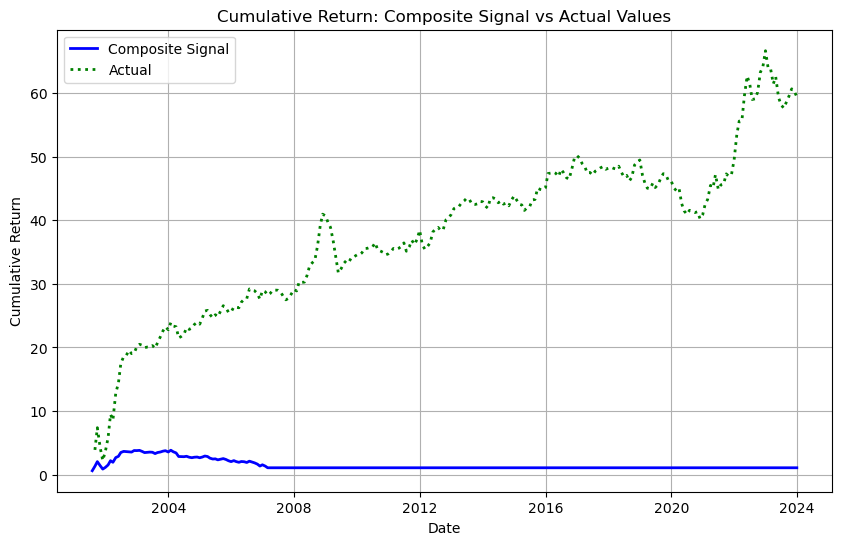

Correlation: -0.6378445398723323
Mean Squared Error: 1491.8858185102222


In [16]:
composite_cumulative_return = composite_signal.cumsum()
actual_cumulative_return = y.cumsum()
composite_cumulative_return = composite_cumulative_return.interpolate()
actual_cumulative_return = actual_cumulative_return.interpolate()


plt.figure(figsize=(10, 6))
plt.plot(composite_cumulative_return.index, composite_cumulative_return, label="Composite Signal", color='blue', linestyle='-', linewidth=2)
plt.plot(actual_cumulative_return.index, actual_cumulative_return, label="Actual", color='green', linestyle=':', linewidth=2)
plt.title("Cumulative Return: Composite Signal vs Actual Values")
plt.xlabel("Date")  # or "Index" if you're using indices
plt.ylabel("Cumulative Return")
plt.legend(loc='best')

plt.grid(True)
plt.show()

composite_cumulative_return, actual_cumulative_return = composite_cumulative_return.align(actual_cumulative_return, join='inner')
correlation = composite_cumulative_return.corr(actual_cumulative_return)
mse = mean_squared_error(actual_cumulative_return, composite_cumulative_return)

print(f"Correlation: {correlation}")
print(f"Mean Squared Error: {mse}")

LinearRegression
  Mean Squared Error: 0.65416543395014
  Correlation: 0.7161802013300206
  Mean Return: 0.2209
  Volatility: 0.8315
  Sharpe Ratio: 0.2657
  T-Statistic: 4.3573
  Start Date: 2001-08-31 00:00:00
  End Date: 2023-12-29 00:00:00
--------------------------------------------------
 
RandomForestRegressor
  Mean Squared Error: 0.18218359377519358
  Correlation: 0.9799515925683528
  Mean Return: 0.2269
  Volatility: 0.7782
  Sharpe Ratio: 0.2916
  T-Statistic: 4.7832
  Start Date: 2001-08-31 00:00:00
  End Date: 2023-12-29 00:00:00
--------------------------------------------------
 
XGBRegressor
  Mean Squared Error: 2.450920086288887e-07
  Correlation: 0.9999999251103365
  Mean Return: 0.2209
  Volatility: 1.1608
  Sharpe Ratio: 0.1903
  T-Statistic: 3.1212
  Start Date: 2001-08-31 00:00:00
  End Date: 2023-12-29 00:00:00
--------------------------------------------------
 
SVR
  Mean Squared Error: 0.6249153360956077
  Correlation: 0.8575122048922869
  Mean Return: 0.1674

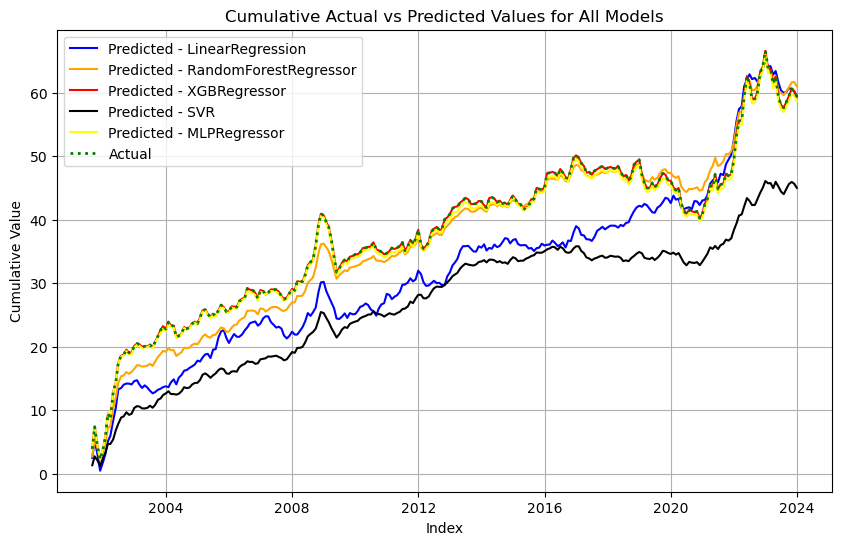

In [17]:
plt.figure(figsize=(10, 6))

colors = {
    "LinearRegression": 'blue',
    "RandomForestRegressor": 'orange',
    "XGBRegressor": 'red',
    "SVR": 'black',
    "MLPRegressor": 'yellow'
}
for algo in algos:
    algo.fit(X, y)
    y_test_pred = pd.Series(algo.predict(X), index=X.index)
    print(type(algo).__name__)
    print(f"  Mean Squared Error: {mean_squared_error(y, y_test_pred)}")
    print(f"  Correlation: {y_test_pred.corr(y)}")
    print(summary_stats(y_test_pred))
    plt.plot(y_test_pred.index, y_test_pred.cumsum(), label=f"Predicted - {type(algo).__name__}", color=colors[type(algo).__name__])

plt.plot(y.index, y.cumsum(), label="Actual", color='green', linewidth=2, linestyle=':')
plt.title("Cumulative Actual vs Predicted Values for All Models")
plt.xlabel("Index")
plt.ylabel("Cumulative Value")
plt.legend()  
plt.grid(True) 
plt.show()

C:\Users\lam ngoe\AppData\Local\Temp\ipykernel_20308\2199591628.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


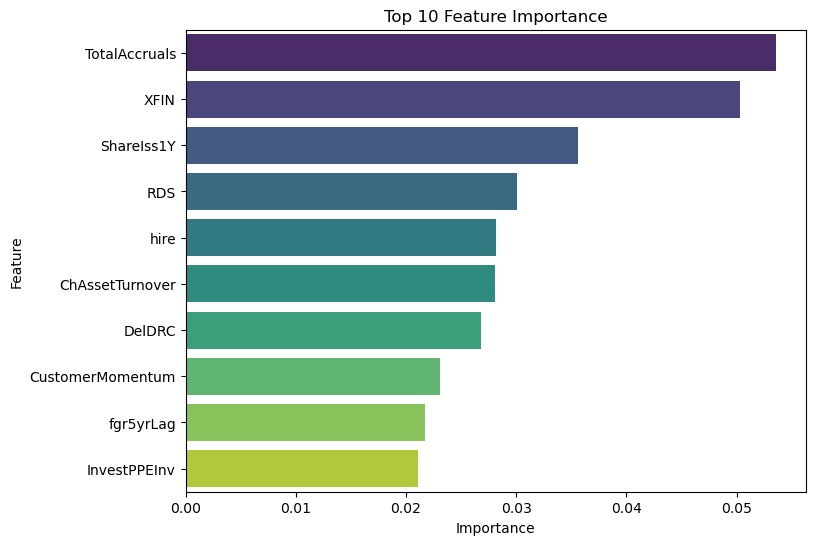

In [18]:
import seaborn as sns

feature_importance = rf.feature_importances_

# Create a DataFrame for easy handling
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the features by importance in descending order and get the top 10
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 most important features
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Top 10 Feature Importance")
plt.show()

C:\Users\lam ngoe\AppData\Local\Temp\ipykernel_20308\3796129435.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df2, palette='viridis')


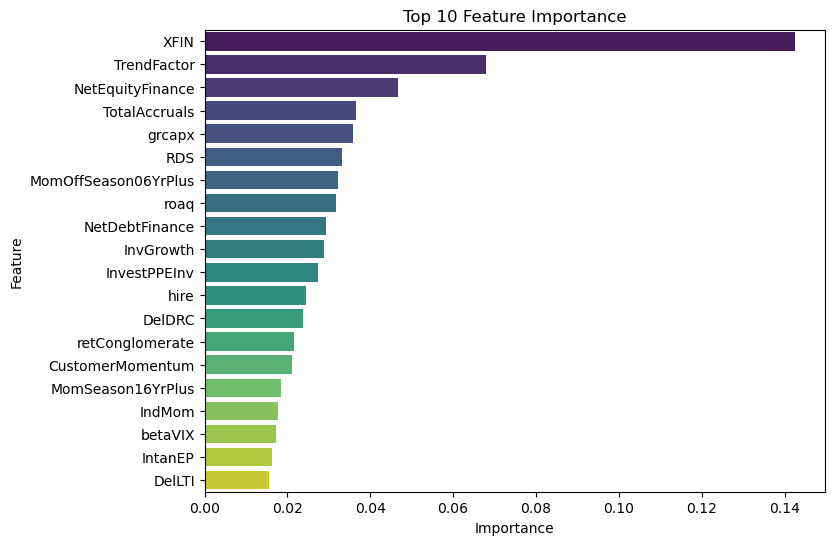

In [24]:
feature_importance = xgb_model.feature_importances_
importance_df2 = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

importance_df2 = importance_df2.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df2, palette='viridis')
plt.title("Top 10 Feature Importance")
plt.show()

In [20]:
allsignal = openap.dl_all_signals('pandas')

Enter your WRDS username [lam ngoe]: lnn226
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  n


You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done

Data is downloaded: 6 mins


In [23]:
allsignal.head()

,permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,BM,BMdec,BPEBM,Beta,BetaFP,BetaLiquidityPS,BetaTailRisk,BidAskSpread,BookLeverage,BrandInvest,CBOperProf,CF,CPVolSpread,Cash,CashProd,ChAssetTurnover,ChEQ,ChForecastAccrual,ChInv,ChInvIA,ChNAnalyst,ChNNCOA,ChNWC,ChTax,ChangeInRecommendation,CitationsRD,CompEquIss,CompositeDebtIssuance,ConsRecomm,ConvDebt,CoskewACX,Coskewness,CredRatDG,CustomerMomentum,DebtIssuance,DelBreadth,DelCOA,DelCOL,DelDRC,DelEqu,DelFINL,DelLTI,DelNetFin,DivInit,DivOmit,DivSeason,DivYieldST,DolVol,DownRecomm,EBM,EP,EarnSupBig,EarningsConsistency,EarningsForecastDisparity,EarningsStreak,EarningsSurprise,EntMult,EquityDuration,ExchSwitch,ExclExp,FEPS,FR,FirmAge,FirmAgeMom,ForecastDispersion,Frontier,GP,Governance,GrAdExp,GrLTNOA,GrSaleToGrInv,GrSaleToGrOverhead,Herf,HerfAsset,HerfBE,High52,IO_ShortInterest,IdioVol3F,IdioVolAHT,Illiquidity,IndIPO,IndMom,IndRetBig,IntMom,IntanBM,...,Mom6m,Mom6mJunk,MomOffSeason,MomOffSeason06YrPlus,MomOffSeason11YrPlus,MomOffSeason16YrPlus,MomRev,MomSeason,MomSeason06YrPlus,MomSeason11YrPlus,MomSeason16YrPlus,MomSeasonShort,MomVol,NOA,NetDebtFinance,NetDebtPrice,NetEquityFinance,NetPayoutYield,NumEarnIncrease,OPLeverage,OScore,OperProf,OperProfRD,OptionVolume1,OptionVolume2,OrderBacklog,OrderBacklogChg,OrgCap,PS,PatentsRD,PayoutYield,PctAcc,PctTotAcc,PredictedFE,PriceDelayRsq,PriceDelaySlope,PriceDelayTstat,ProbInformedTrading,RD,RDAbility,RDIPO,RDS,RDcap,REV6,RIO_Disp,RIO_MB,RIO_Turnover,RIO_Volatility,RIVolSpread,RealizedVol,Recomm_ShortInterest,ResidualMomentum,ReturnSkew,ReturnSkew3F,RevenueSurprise,RoE,SP,ShareIss1Y,ShareIss5Y,ShareRepurchase,ShareVol,ShortInterest,SmileSlope,Spinoff,SurpriseRD,Tax,TotalAccruals,TrendFactor,UpRecomm,VarCF,VolMkt,VolSD,VolumeTrend,XFIN,betaVIX,cfp,dCPVolSpread,dNoa,dVolCall,dVolPut,fgr5yrLag,grcapx,grcapx3y,hire,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M,Price,Size,STreversal
0,10000,198601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.058804,NaN,NaN,0.0,0.147242,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.065278,NaN,NaN,-2.238314,-2.103345,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.475907,-2.778819,-0.000000
1,10000,198602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.732394,NaN,-0.028608,NaN,NaN,0.0,0.172087,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.031004,NaN,NaN,0.729553,0.810183,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.785175e-08,NaN,-1.178655,-2.481568,0.257143
2,10000,198603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [38]:
top_20_signals = [
    "XFIN", "TrendFactor", "NetEquityFinance", "TotalAccruals", "grcapx",
    "RDS", "MomOffSeason06YrPlus", "roaq", "NetDebtFinance", "InvGrowth",
    "InvestPPEInv", "hire", "DelDRC", "retConglomerate", "CustomerMomentum",
    "MomSeason16YrPlus", "IndMom", "betaVIX", "IntanEP", "DelLTI"
]
allsignal_20 = allsignal[["permno", "yyyymm"] + top_20_signals]

In [41]:
allsignal_20 = allsignal_20.dropna(thresh=int(len(top_20_signals)*0.8))

In [48]:
allsignal_20.to_csv('allsignal_20.csv.gz', index=False, compression='gzip')

In [43]:
allsignal_20.head(10)

,permno,yyyymm,XFIN,TrendFactor,NetEquityFinance,TotalAccruals,grcapx,RDS,MomOffSeason06YrPlus,roaq,NetDebtFinance,InvGrowth,InvestPPEInv,hire,DelDRC,retConglomerate,CustomerMomentum,MomSeason16YrPlus,IndMom,betaVIX,IntanEP,DelLTI
183,10001,199901,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.027581,-0.016140,0.065421,NaN,-0.003704,0.158491,NaN,-0.009186,NaN,NaN,0.102473,0.000048,0.099803,0.001519
184,10001,199902,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.022359,-0.016140,0.065421,NaN,-0.003704,0.158491,NaN,-0.047183,NaN,NaN,0.049211,0.000155,0.124949,0.001519
185,10001,199903,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.020457,0.016069,0.065421,NaN,-0.003704,0.158491,NaN,0.007086,NaN,NaN,-0.066548,-0.010097,0.149366,0.001519
186,10001,199904,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.020823,0.016069,0.065421,NaN,-0.003704,0.158491,NaN,0.042973,NaN,NaN,-0.074677,-0.003417,0.109955,0.001519
187,10001,199905,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.018150,0.016069,0.065421,NaN,-0.003704,0.158491,NaN,0.048538,NaN,NaN,0.005686,-0.003171,0.109856,0.001519
188,10001,199906,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.022018,0.026437,0.065421,NaN,-0.003704,0.158491,NaN,0.070770,NaN,NaN,0.032518,-0.006202,0.340071,0.001519
189,10001,199907,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.017428,0.026437,0.065421,NaN,-0.003704,0.158491,NaN,0.022581,NaN,NaN,0.083611,0.015670,0.362681,0.001519
190,10001,199908,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.013961,0.026437,0.065421,NaN,-0.003704,0.158491,NaN,-0.021913,NaN,NaN,0.092641,0.004919,0.172513,0.001519
191,10001,199909,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.016350,0.005001,0.065421,NaN,-0.003704,0.158491,NaN,-0.022286,NaN,NaN,0.117305,0.013206,0.241111,0.001519
192,10001,199910,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.015003,0.005001,0.065421,NaN,-0.003704,0.158491,NaN,0.007756,NaN,NaN,-0.012221,0.000260,0.168026,0.001519


In [35]:
crsp_df = pd.read_csv("crsp_data.csv")

In [36]:
crsp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4047630 entries, 0 to 4047629
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   permno  int64  
 1   date    object 
 2   ret     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 92.6+ MB


In [37]:
crsp_df.head(10)

,permno,date,ret
0,10000,1986-01-31,NaN
1,10000,1986-02-28,-25.7143
2,10000,1986-03-31,36.5385
3,10000,1986-04-30,-9.8592
4,10000,1986-05-30,-22.2656
5,10000,1986-06-30,-0.5025
6,10000,1986-07-31,-8.0808
7,10000,1986-08-29,-61.5385
8,10000,1986-09-30,-5.7143
9,10000,1986-10-31,-24.2424


In [45]:
crsp_df['permno'] = crsp_df['permno'].astype('int64')
crsp_df['yyyymm'] = crsp_df['yyyymm'].astype('int64')

allsignal_20['permno'] = allsignal_20['permno'].astype('int64')
allsignal_20['yyyymm'] = allsignal_20['yyyymm'].astype('int64')
merged_df = pd.merge(crsp_df, allsignal_20, on=["permno", "yyyymm"], how="inner")

merged_df = merged_df.dropna(subset=["ret"])

In [50]:
merged_df

,permno,date,ret,yyyymm,XFIN,TrendFactor,NetEquityFinance,TotalAccruals,grcapx,RDS,MomOffSeason06YrPlus,roaq,NetDebtFinance,InvGrowth,InvestPPEInv,hire,DelDRC,retConglomerate,CustomerMomentum,MomSeason16YrPlus,IndMom,betaVIX,IntanEP,DelLTI
0,10001,1999-01-29,0.0000,199901,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.027581,-0.016140,0.065421,NaN,-0.003704,0.158491,NaN,-0.009186,NaN,NaN,0.102473,0.000048,0.099803,0.001519
1,10001,1999-02-26,-9.0909,199902,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.022359,-0.016140,0.065421,NaN,-0.003704,0.158491,NaN,-0.047183,NaN,NaN,0.049211,0.000155,0.124949,0.001519
2,10001,1999-03-31,1.3143,199903,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.020457,0.016069,0.065421,NaN,-0.003704,0.158491,NaN,0.007086,NaN,NaN,-0.066548,-0.010097,0.149366,0.001519
3,10001,1999-04-30,1.4286,199904,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.020823,0.016069,0.065421,NaN,-0.003704,0.158491,NaN,0.042973,NaN,NaN,-0.074677,-0.003417,0.109955,0.001519
4,10001,1999-05-28,-2.1127,199905,0.081598,NaN,0.016753,-0.021627,0.343498,NaN,-0.018150,0.016069,0.065421,NaN,-0.003704,0.158491,NaN,0.048538,NaN,NaN,0.005686,-0.003171,0.109856,0.001519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694564,93436,2023-08-31,-3.4962,202308,0.040382,0.133927,-0.007489,-0.223286,-1.216275,-260122.58,-0.019062,0.030521,0.053520,-1.155350,-0.247043,-0.251513,0.006064,-0.078938,0.023122,NaN,0.247524,-0.009743,NaN,-0.019852
1694565,93436,2023-09-29,-3.0456,202309,0.040382,0.155592,-0.007489,-0.223286,-1.216275,-260122.58,-0.020852,0.031129,0.053520,-1.155350,-0.247043,-0.251513,0.006064,-0.022955,0.054521,NaN,0.178126,-0.027900,NaN,-0.019852
1694566,93436,2023-10-31,-19.7346,202310,0.040382,0.152258,-0.007489,-0.223286,-1.216275,-260122.58,-0.025114,0.031129,0.053520,-1.160941,-0.247043,-0.251513,0.006064,-0.139206,-0.025424,NaN,0.232628,0.011033,-2.853455,-0.019852
1694567,93436,2023-11-30,19.5379,202311,0.040382,0.086506,-0.007489,-0.223286,-1.216275,-260122.58,-0.021164,0.031129,0.053520,-1.160941,-0.247043,-0.251513,0.006064,0.012961,0.083343,NaN,-0.006187,-0.013998,-2.332660,-0.019852


In [49]:
!pip install lifelines

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=72b71053d28d0e9dedc4143d153f2057118f11708a0d0e910b853afb1267ddcb
  Stored in directory: c:\users\lam ngoe\appdata\local\pip\cache\wheels\50\37\21\0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [59]:
import pandas as pd
from lifelines import CoxPHFitter

# Step 1: Define Death (return <= -50% over next 6 months)
merged_df = merged_df.sort_values(by=['permno', 'yyyymm'])

# Rolling 6-month return
merged_df['future_ret_6m'] = merged_df.groupby('permno')['ret'].rolling(window=6, min_periods=1).sum().shift(-6).reset_index(level=0, drop=True)

# Event: 1 if future 6M return <= -50%
merged_df['event'] = (merged_df['future_ret_6m'] <= -0.5).astype(int)

# Step 2: Duration
# For now, simple duration of 1 (because each row is one monthly observation)
merged_df['duration'] = 1

survival_df = merged_df[["duration", "event"] + top_20_signals].dropna()

# Step 4: Train Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(survival_df, duration_col='duration', event_col='event')


# Step 5: Summary Output
cph.print_summary()  # Hazard Ratios, p-values, confidence intervals


C:\anaconda3\Lib\site-packages\lifelines\utils\__init__.py:1100: ConvergenceWarning: Column(s) ['betaVIX'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 7780 total observations, 4824 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 7780
number of events observed = 2956
   partial log-likelihood = -25771.40
         time fit was run = 2025-04-25 20:32:19 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
XFIN                 -1.30      0.27      1.02           -3.31            0.70                0.04                2.02
TrendFactor          -0.26      0.77      0.11           -0.47           -0.05                0.63                0.95
NetEquityFinance      0.70      2.02      0.97           -1.20            2.61                0.30               13.55
TotalAccruals         0.30      1.35      0.17           -0.03            0.63                0.97                1.88
grcapx                0.04      1.04      0.02           -0.00            0.07                1.00                1.07
RDS                  -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
MomOffSeason06YrPlus  3.95     52.03      1.20            1.60            6.31                4.94              547.44
roaq                  2.26      9.60      0.66            0.96            3.56                2.62               35.15
NetDebtFinance        1.03      2.81      0.87           -0.67            2.74                0.51               15.44
InvGrowth            -0.05      0.96      0.01           -0.07           -0.02                0.93                0.98
InvestPPEInv          0.37      1.45      0.25           -0.12            0.87                0.88                2.39
hire                 -0.15      0.86      0.12           -0.39            0.10                0.68                1.10
DelDRC                2.49     12.03      0.91            0.70            4.28                2.01               71.90
retConglomerate      -1.18      0.31      0.25           -1.67           -0.69                0.19                0.50
CustomerMomentum      0.45      1.57      0.23            0.00            0.90                1.00                2.47
MomSeason16YrPlus    -0.24      0.79      0.22           -0.68            0.20                0.51                1.22
IndMom               -0.00      1.00      0.12           -0.25            0.24                0.78                1.27
betaVIX              -3.54      0.03      2.26           -7.97            0.88                0.00                2.41
IntanEP               0.42      1.53      0.08            0.27            0.57                1.31                1.77
DelLTI                1.30      3.66      0.57            0.19            2.41                1.20               11.14

                      cmp to     z      p  -log2(p)
covariate                                          
XFIN                    0.00 -1.27   0.20      2.30
TrendFactor             0.00 -2.45   0.01      6.12
NetEquityFinance        0.00  0.72   0.47      1.09
TotalAccruals           0.00  1.76   0.08      3.68
grcapx                  0.00  1.93   0.05      4.23
RDS                     0.00 -1.28   0.20      2.31
MomOffSeason06YrPlus    0.00  3.29 <0.005      9.97
roaq                    0.00  3.41 <0.005     10.61
NetDebtFinance          0.00  1.19   0.23      2.09
InvGrowth               0.00 -4.06 <0.005     14.32
InvestPPEInv            0.00  1.47   0.14      2.83
hire                    0.00 -1.17   0.24      2.04
DelDRC                  0.00  2.73   0.01      7.29
retConglomerate         0.00 -4.74 <0.005     18.87
CustomerMomentum        0.00  1.97   0.05      4.34
MomSeason16YrPlus       0.00 -1.08   0.28      1.83
IndMom                  0.00 -0.03   0.98      0.04
betaVIX                 0.

In [64]:
# 1. Get summary with index reset
summary_df = cph.summary.reset_index()

# 2. Rename the index column to "Acronym" (whatever it's called — find out)
summary_df.columns = ['Acronym' if col == summary_df.columns[0] else col for col in summary_df.columns]

# 3. Map the detailed definition from another dataframe
# Make sure signal_df has 'Acronym' and 'Detailed Definition' columns
summary_df['Detailed Definition'] = summary_df['Acronym'].map(
    signal_df.set_index('Acronym')['Detailed Definition']
)

# 4. (Optional) Move 'Detailed Definition' next to Acronym for display
cols = ['Acronym', 'Detailed Definition'] + [col for col in summary_df.columns if col not in ['Acronym', 'Detailed Definition']]
summary_df = summary_df[cols]

summary_df

,Acronym,Detailed Definition,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,XFIN,Sale of common stock (sstk) minus dividends (d...,-1.303655,0.271538,1.023376,-3.309435,0.702125,0.036537,2.018037,0.0,-1.273877,2.027071e-01,2.302532
1,TrendFactor,See paper section 2.1 and 2.2,-0.259797,0.771208,0.106140,-0.467828,-0.051767,0.626361,0.949550,0.0,-2.447689,1.437759e-02,6.120034
2,NetEquityFinance,Sale of common stock (sstk) minus purchase of...,0.703290,2.020389,0.970864,-1.199568,2.606149,0.301324,13.546781,0.0,0.724396,4.688225e-01,1.092886
3,TotalAccruals,Before 1988: Change in net working capital ((a...,0.299704,1.349459,0.169947,-0.033385,0.632793,0.967166,1.882862,0.0,1.763520,7.781281e-02,3.683848
4,grcapx,Growth rate of capital expenditures (capx) rel...,0.035005,1.035625,0.018106,-0.000482,0.070492,0.999518,1.073036,0.0,1.933358,5.319214e-02,4.232643
5,RDS,Define Dirty Surplus as annual change in marke...,-0.000017,0.999983,0.000014,-0.000044,0.000009,0.999956,1.000009,0.0,-1.277343,2.014813e-01,2.311282
6,MomOffSeason06YrPlus,Average return in other months over the preced...,3.951760,52.026839,1.200782,1.598271,6.305249,4.944475,547.437738,0.0,3.290989,9.983577e-04,9.968156
7,roaq,Quarterly net income (ibq) divided by lagged t...,2.261426,9.596760,0.662367,0.963210,3.559641,2.620095,35.150563,0.0,3.414159,6.397924e-04,10.610109
8,NetDebtFinance,Long-term debt issuance (dltis) minus long-ter...,1.033858,2.811894,0.868894,-0.669143,2.736859,0.512147,15.438420,0.0,1.189855,2.341033e-01,2.094783
9,InvGrowth,Defate invt growth using gnp deflator. Signal...,-0.045457,0.955560,0.011192,-0.067394,-0.023521,0.934827,0.976754,0.0,-4.061495,4.875948e-05,14.323958
